In [4]:

import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

symbols = ["AAPL", "MSFT", "AMZN", "INTC", "GOOGL"]
prices = pd.DataFrame()
for SYMBOL in symbols:
    SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

    stk = cira.Stock(SYMBOL)

    if not exists(SYM_HIST_FILE): # chacheing historical data  
        start = datetime(2016, 1, 1)
        end = datetime.now().date()
        stk.save_historical_data(SYM_HIST_FILE, start, end)

    data = stk.load_historical_data(SYM_HIST_FILE)
    data.drop(columns=["symbol"], inplace=True)
    prices[SYMBOL] = data["close"]
prices.head()

,AAPL,MSFT,AMZN,INTC,GOOGL
timestamp,,,,,
2016-01-04 05:00:00+00:00,23.88,48.52,31.85,27.05,37.93
2016-01-05 05:00:00+00:00,23.28,48.74,31.69,26.92,38.03
2016-01-06 05:00:00+00:00,22.82,47.86,31.63,26.32,37.92
2016-01-07 05:00:00+00:00,21.86,46.19,30.40,25.33,37.01
2016-01-08 05:00:00+00:00,21.98,46.34,30.35,25.07,36.50


<Axes: xlabel='timestamp'>

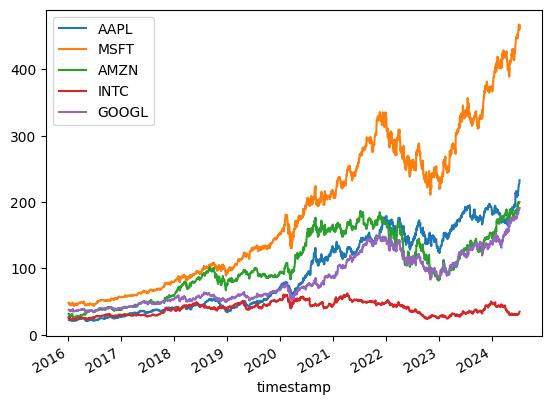

In [5]:
prices.plot()

In [48]:
from numpy import ndarray
from pandas import DataFrame


class SimpleSmaStrategy(cira.strategy.Strategy):
    """
    This is a full strategy implemention, 
    were we look at the moving avrage.  
    """

    def __init__(self, sma=50, max_alloc=0.75) -> None:
        super().__init__(name="SimpleSmaStrategy")
        self.sma = sma
        self.max_alloc = max_alloc 
        self.pl_loss = -0.02
        self.pl_win  = 0.05
        self.allocations = []

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash=float)-> ndarray:
        signal = self.alpha(feature_data)
        if len(portfolio.shape) == 1: 
            portfolio = np.array([portfolio])
        portfolio_change = self.portfolio_construction(signal, prices, portfolio, cash)
        portfolio_change = self.transaction_cost(portfolio_change, portfolio, prices, cash)
        portfolio_change = self.risk(portfolio, portfolio_change, prices)
        self.allocations.append(portfolio_change)
        return portfolio_change

    def alpha(self, feature_data: DataFrame) -> ndarray: 
        data = feature_data.copy()
        for sym in feature_data.keys():
            data[f"{sym}_sma"]  =  feature_data[sym].rolling(window=self.sma).mean() 

        signal = np.zeros(len(feature_data.keys()))
        for i, sym in enumerate(feature_data.keys()):
            if data[sym].iloc[-1] > data[f"{sym}_sma"].iloc[-1]:
                signal[i] = -1
            else: 
                signal[i] = 1
        return signal

    def portfolio_construction(self, signals, prices, portfolio, cash) -> ndarray:
        """ Equal weighting """
        equal_weight = 1 / len(prices.keys())
        investment_per_asset = cash * equal_weight
        portfolio_change = np.zeros(len(prices.keys()))
        for i, sym in enumerate(prices.keys()):
            shares_to_buy = investment_per_asset / prices.iloc[-1][sym]
            if signals[i] < 0: 
                portfolio_change[i] = -1 * shares_to_buy
            else: 
                portfolio_change[i] = shares_to_buy
        value = np.matmul(portfolio[-1], prices.iloc[-1].values)
        new_value = np.matmul(portfolio[-1] + portfolio_change, prices.iloc[-1].values)
        while (new_value/(value + 1)) > self.max_alloc:
            portfolio_change -= 1
            value = np.matmul(portfolio[-1], prices.iloc[-1].values)
            new_value = np.matmul(portfolio[-1] + portfolio_change, prices.iloc[-1].values)
            for i in range(len(prices.keys())):
                if (portfolio[-1] + portfolio_change)[i] < 0:
                    portfolio_change[i] = -portfolio[-1][i]
        return portfolio_change 


    def transaction_cost(self, portfolio_change, portfolio, prices, cash) -> ndarray: 
        while cira.strategy.fees(prices.iloc[-1], np.abs(portfolio_change)) > cash:
            portfolio_change -= 1
            for i in range(len(prices.keys())):
                if (portfolio[-1] + portfolio_change)[i] < 0:
                    portfolio_change[i] = -portfolio[-1][i]
        return portfolio_change 


    def risk(self, portfolio, portfolio_change, prices) -> ndarray:
        for i, sym in enumerate(prices.keys()):
            pl = (portfolio[-1][i] + portfolio_change[i]) * prices.iloc[0][sym] - (portfolio[-1][i] + portfolio_change[i]) * prices.iloc[-1][sym]
            if pl < self.pl_loss or pl > self.pl_win:
                portfolio_change[i] = -portfolio[-1][i]
        return portfolio_change
         

<Axes: xlabel='timestamp'>

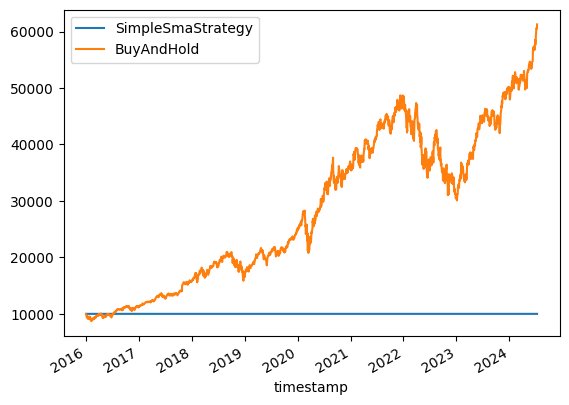

In [49]:
from cira.strategy import back_test_against_buy_and_hold as back_test

strat = SimpleSmaStrategy()
back_test(strat, prices, prices, 10_000).plot()

<Axes: >

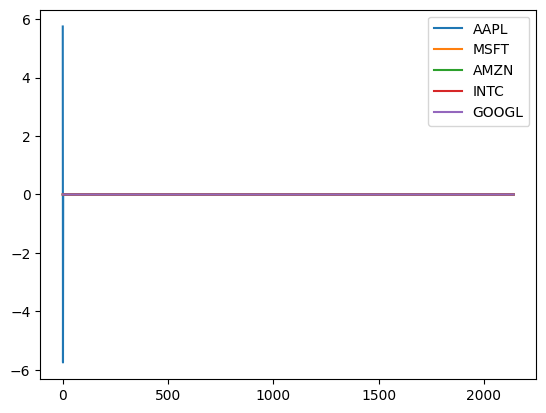

In [57]:
pd.DataFrame({sym:np.array(strat.allocations)[:,i] for i, sym in enumerate(prices.keys())}).plot()
